In [1]:
import tensorflow as tf 
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3

In [3]:
import os
from PIL import Image

# 1. DEFINE YOUR FOLDERS
# The folder containing your organized constellation subfolders
input_folder = r'C:\Users\BIT\OneDrive\Orion world\OrionWorld\MLProjects\Constellations' 
# The main folder where cropped subfolders will be created
output_folder = r'C:\Users\BIT\OneDrive\Orion world\OrionWorld\MLProjects\FinalConstellations' 

# 2. DEFINE CROP VALUES (in pixels)
pixels_to_crop_top = 90
pixels_to_crop_bottom = 100
pixels_to_crop_left = 120
pixels_to_crop_right = 0

# --- SCRIPT START ---
# Create the main output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

print("Starting image cropping...")

# Loop through each constellation subfolder in the input directory
for constellation_name in os.listdir(input_folder):
    constellation_input_path = os.path.join(input_folder, constellation_name)
    constellation_output_path = os.path.join(output_folder, constellation_name)

    # Check if it's actually a directory
    if os.path.isdir(constellation_input_path):
        # Create a corresponding output subfolder
        if not os.path.exists(constellation_output_path):
            os.makedirs(constellation_output_path)
        
        print(f"Processing folder: {constellation_name}")

        # Loop through all the image files in the current constellation subfolder
        for filename in os.listdir(constellation_input_path):
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img_path = os.path.join(constellation_input_path, filename)
                    img = Image.open(img_path)
                    
                    width, height = img.size
                    crop_box = (
                        pixels_to_crop_left, 
                        pixels_to_crop_top, 
                        width - pixels_to_crop_right, 
                        height - pixels_to_crop_bottom
                    )
                    
                    cropped_img = img.crop(crop_box)
                    cropped_img.save(os.path.join(constellation_output_path, filename))

                except Exception as e:
                    print(f"Could not process {filename}. Error: {e}")

print(f"\nCropping complete! Your organized, cropped images are in '{output_folder}'.")

Starting image cropping...
Processing folder: CanisMajor
Processing folder: Cassiopeia
Processing folder: Crux
Processing folder: Leo
Processing folder: Orion
Processing folder: Scorpius
Processing folder: UrsaMajor
Processing folder: UrsaMinor

Cropping complete! Your organized, cropped images are in 'C:\Users\BIT\OneDrive\Orion world\OrionWorld\MLProjects\FinalConstellations'.


In [4]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "FinalConstellations",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 433 files belonging to 8 classes.


In [5]:
class_names= dataset.class_names

In [6]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
    ds_size= len(ds)

    if(shuffle):
        ds= ds.shuffle(shuffle_size,seed=12)
        
    train_size= int(train_split* ds_size)
    val_size= int(val_split* ds_size)

    train_ds= ds.take(train_size)

    val_ds= ds.skip(train_size).take(val_size)
    test_ds= ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [7]:
train_ds,val_ds,test_ds= get_dataset_partitions_tf(dataset)

In [8]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

In [10]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2), # Add random zoom
    layers.RandomContrast(0.2), # Add random contrast
])

In [15]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import EfficientNetB0

# --- Define Constants ---
IMAGE_SIZE = 256
CHANNELS = 3
n_classes = 8
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# --- 2. Load the More Powerful Pre-trained Base Model (Frozen) ---
base_model = EfficientNetB0(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# --- 3. Build the Final Sequential Model ---
model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    
    # Data Augmentation Layers (these remain the same)
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    
    # EfficientNet has a different preprocessing step (rescaling is built-in)
    # We apply it using a Lambda layer.
    layers.Lambda(tf.keras.applications.efficientnet.preprocess_input),
    
    # The Pre-trained EfficientNetB0 Base Model
    base_model,
    
    # Classification Layers (these remain the same)
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 256, 256, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_2 (RandomZoom)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_2               │ (None, 256, 256, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,059,819 (15.49 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [16]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 256, 256, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_2 (RandomZoom)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_2               │ (None, 256, 256, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,059,819 (15.49 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [17]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history= model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data= val_ds,
    verbose=1,
    epochs=30
)

Epoch 1/30


11/11 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.1457 - loss: 2.0942 - val_accuracy: 0.3438 - val_loss: 1.8875
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.3726 - loss: 1.8154 - val_accuracy: 0.5938 - val_loss: 1.6361
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.4869 - loss: 1.6451 - val_accuracy: 0.5625 - val_loss: 1.5227
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5834 - loss: 1.4838 - val_accuracy: 0.5000 - val_loss: 1.4131
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6511 - loss: 1.3533 - val_accuracy: 0.6562 - val_loss: 1.2415
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6508 - loss: 1.2697 - val_accuracy: 0.5938 - val_loss: 1.2142
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.6519 - loss: 1.1812 - val_accuracy: 0.6250 - val_loss: 1.1572
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6533 - loss: 1.1121 - val_accuracy: 0.7812 - val_loss: 1.0730
Epo

first image to predict
first image's actual label: UrsaMinor
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
UrsaMinor


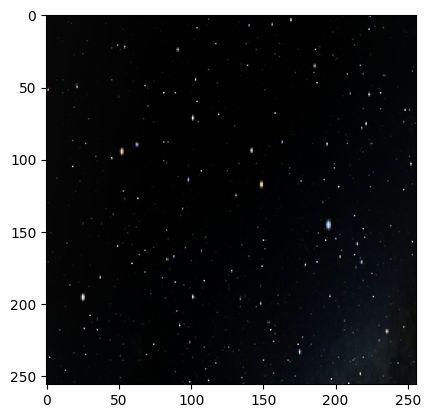

In [19]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label= labels_batch[0]

    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:",class_names[first_label])

    batch_prediction=model.predict(images_batch)
    print(class_names[np.argmax(batch_prediction[0])])

In [34]:
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Corrected Snippet ---

# 1. Define the path to your test image
img_path = r'C:\Users\BIT\OneDrive\Orion world\OrionWorld\MLProjects\image.png'
# This loads the image and ensures it's the 256x256 size your model expects.
img_tensor = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))

# 3. Convert the image to a NumPy array
# This gives it the shape (256, 256, 3)
img_array = image.img_to_array(img_tensor)

# 4. Add the batch dimension
# The shape is now (1, 256, 256, 3), which the model can accept.
img_batch = np.expand_dims(img_array, axis=0)

# 5. Make the prediction
batch_prediction = model.predict(img_batch)

# 6. Get the final result
predicted_class_index = np.argmax(batch_prediction[0])
predicted_class_name = class_names[predicted_class_index]

print(f"The predicted constellation is: {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
The predicted constellation is: Leo


In [35]:
model.save('constella_efficientNet_Final_2.keras')